In [2]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = 15, 10

In [3]:
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]

def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]

def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    # Wenqi: Format of ground truth (for 10000 query vectors):
    #   1000(topK), [1000 ids]
    #   1000(topK), [1000 ids]
    #        ...     ...
    #   1000(topK), [1000 ids]
    # 10000 rows in total, 10000 * 1001 elements, 10000 * 1001 * 4 bytes
    return a.reshape(-1, d + 1)[:, 1:].copy()

def fvecs_read(fname):
    return ivecs_read(fname).view('float32')

In [4]:
dbname = 'SIFT1M'
num_vec_train = int(1e4)
num_query_learn = int(1e0)

if dbname.startswith('SIFT'):
    # SIFT1M to SIFT1000M
    dbsize = int(dbname[4:-1])
    xb = mmap_bvecs('/mnt/scratch/wenqi/Faiss_experiments/bigann/bigann_base.bvecs')
    xq = mmap_bvecs('/mnt/scratch/wenqi/Faiss_experiments/bigann/bigann_query.bvecs')
    gt = ivecs_read('/mnt/scratch/wenqi/Faiss_experiments/bigann/gnd/idx_%dM.ivecs' % dbsize)

    N_VEC = int(dbsize * 1000 * 1000)

    # trim xb to correct size
    xb = xb[:dbsize * 1000 * 1000]

    # Wenqi: load xq to main memory and reshape
    xq = xq.astype('float32').copy()
#     xq = np.array(xq, dtype=np.float32)
    xb = xb.astype('float32').copy()
    gt = np.array(gt, dtype=np.int32)

    print("Vector shapes:")
    print("Base vector xb: ", xb.shape)
    print("Query vector xq: ", xq.shape)
    print("Ground truth gt: ", gt.shape)
else:
    print('unknown dataset', dbname, file=sys.stderr)
    sys.exit(1)

dim = xb.shape[1] # should be 128
nq = xq.shape[0]

# Normalize all to 0~1
xb = xb / 256
xq = xq / 256
xq_learn = xq[:num_query_learn]
xt = xb[:num_vec_train]

Vector shapes:
Base vector xb:  (1000000, 128)
Query vector xq:  (10000, 128)
Ground truth gt:  (10000, 1000)


In [5]:
# Creating a DeepAutoencoder class

# We partition the data to 32 shards (bottleneck dimension)
# The input data is 128-dimension
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
#             torch.nn.Sigmoid()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def loss_func(reconstructed_feat, input_feat, query, hidden_feat, query_hidden_feat):
    """
    centroid vectors: same shape as hidden_feat
    """
    
    num_vec = reconstructed_feat.shape[0]
    full_dim = reconstructed_feat.shape[1]
    hidden_dim = hidden_feat.shape[1]
    query_num = query.shape[0]
    
    hidden_feat_factor = full_dim / hidden_dim
    
    loss = 0
    # For each query, each db vector has a weight
    for i in range(query_num):
        # the closer the distance, the larger the weights
#         weights = torch.ones(num_vec)
        weights = 1 / torch.sum((input_feat - query[i].repeat(num_vec, 1)) ** 2, dim=1)
        print('weights: ', weights, 'min: ', torch.min(weights), 'max: ', torch.max(weights))
        dist = torch.sum((reconstructed_feat - input_feat) ** 2, dim=1)
        part_loss = torch.mean(weights * dist)
        
#         dist_hidden = torch.sum((hidden_feat - query_hidden_feat[i].repeat(num_vec, 1)) ** 2, dim=1)
#         part_loss_hidden = torch.mean(weights * dist_hidden) * hidden_feat_factor
        
#         print("L2 dist loss: ", part_loss, "Hidden dist loss: ", part_loss_hidden)
        
#         loss += part_loss + part_loss_hidden
        
        loss += part_loss 
    
    loss /= query_num 
    
    return loss

In [7]:
# torch.sum((out[0] * xq_learn_tensor[0]))

In [8]:
# torch.sum(out[0].repeat(5000, 1) * xq_learn_tensor, dim=1).shape

In [9]:
num_epochs = 1000 # Wenqi: original iteration = 100
num_partitions = 32

# List that will store the training loss
train_loss = []
validation_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

xt_tensor = torch.FloatTensor(xt)
xq_learn_tensor = torch.FloatTensor(xq_learn)
hidden_feature = model.encoder(xt_tensor)
out = model(xt_tensor)

Loss (Overfit the first 10 queries)

First 1000 iter: 43 -> 1.6 (Recall first 10=0.7)

Second 1000 iter: 1.6 -> 1.25

Third 1000 iter: 1.25 -> 1.11

Fourth 1000 iter: 1.11 -> 1.05 (Recall first 10=0.7)

Maybe the weights should be L2 distance rather than dot product?

out torch.Size([10000, 128]) tensor([[0.5246, 0.5142, 0.4820,  ..., 0.5216, 0.5200, 0.4907],
        [0.5244, 0.5137, 0.4818,  ..., 0.5209, 0.5191, 0.4908],
        [0.5247, 0.5141, 0.4822,  ..., 0.5215, 0.5196, 0.4908],
        ...,
        [0.5241, 0.5135, 0.4818,  ..., 0.5211, 0.5188, 0.4911],
        [0.5249, 0.5137, 0.4816,  ..., 0.5212, 0.5195, 0.4907],
        [0.5244, 0.5141, 0.4820,  ..., 0.5213, 0.5196, 0.4909]],
       grad_fn=<SigmoidBackward>)
xt_tensor torch.Size([10000, 128]) tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0391, 0.0234],
        [0.2539, 0.1367, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
        ...,
        [0.0273, 0.0195, 0.0273,  ..., 0.1758, 0.0625, 0.0898],
        [0.1484, 0.0000, 0.0000,  ..., 0.1055, 0.0156, 0.0312],
        [0.0000, 0.0000, 0.0078,  ..., 0.1172, 0.0117, 0.0000]])
hidden_feature torch.Size([10000, 32]) tensor([[ 0.2066, -0.0411,  0.0467,  ...,  0.1053, -0.0183,  0.1370

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 47 train loss: 0.8160706758499146
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 48 train loss: 0.8209813237190247
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 49 train loss: 0.823842465877533
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 50 train loss: 0.8230041861534119
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 51 train loss: 0.8182008266448975
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 52 train loss: 0.8097785115242004
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0

epoch: 102 train loss: 0.5995901823043823
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 103 train loss: 0.5993937253952026
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 104 train loss: 0.599175751209259
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 105 train loss: 0.5989087820053101
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 106 train loss: 0.5985901951789856
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 107 train loss: 0.5982354879379272
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 108 train loss: 0.597871720790863
weights:  tensor([

epoch: 157 train loss: 0.5904254913330078
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 158 train loss: 0.5903467535972595
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 159 train loss: 0.5902681350708008
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 160 train loss: 0.5901896953582764
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 161 train loss: 0.5901117324829102
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 162 train loss: 0.5900344252586365
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 163 train loss: 0.5899580121040344
weights:  tensor

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 210 train loss: 0.5873203873634338
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 211 train loss: 0.5872785449028015
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 212 train loss: 0.5872365236282349
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 213 train loss: 0.5871950387954712
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 214 train loss: 0.5871537327766418
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 215 train loss: 0.5871129631996155
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 264 train loss: 0.5851574540138245
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 265 train loss: 0.5851159691810608
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 266 train loss: 0.5850743651390076
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 267 train loss: 0.5850324034690857
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 268 train loss: 0.584990382194519
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 269 train loss: 0.5849480032920837
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 317 train loss: 0.5821353793144226
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 318 train loss: 0.5820373296737671
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 319 train loss: 0.5819360613822937
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 320 train loss: 0.5818314552307129
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 321 train loss: 0.5817227959632874
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 322 train loss: 0.5816102623939514
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.

epoch: 371 train loss: 0.5477413535118103
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 372 train loss: 0.5467997789382935
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 373 train loss: 0.5459840893745422
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 374 train loss: 0.5452753305435181
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 375 train loss: 0.5446243286132812
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 376 train loss: 0.5439863801002502
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 377 train loss: 0.5433404445648193
weights:  tensor

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 424 train loss: 0.5166975855827332
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 425 train loss: 0.5161449313163757
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 426 train loss: 0.5155931711196899
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 427 train loss: 0.5150409936904907
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 428 train loss: 0.5144862532615662
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 429 train loss: 0.513922929763794
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2

epoch: 477 train loss: 0.4672454595565796
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 478 train loss: 0.46697232127189636
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 479 train loss: 0.4666725993156433
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 480 train loss: 0.46635738015174866
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 481 train loss: 0.46606680750846863
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 482 train loss: 0.46579161286354065
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 483 train loss: 0.4654981791973114
weights:  te

epoch: 530 train loss: 0.45273011922836304
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 531 train loss: 0.4524240791797638
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 532 train loss: 0.4521157145500183
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 533 train loss: 0.45180580019950867
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 534 train loss: 0.45149317383766174
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 535 train loss: 0.4511782228946686
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 536 train loss: 0.45086148381233215
weights:  te

epoch: 584 train loss: 0.4221150875091553
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 585 train loss: 0.42146679759025574
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 586 train loss: 0.42085957527160645
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 587 train loss: 0.4203810691833496
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 588 train loss: 0.4198971688747406
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 589 train loss: 0.4193207621574402
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 590 train loss: 0.41878437995910645
weights:  ten

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 641 train loss: 0.404081791639328
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 642 train loss: 0.4038521349430084
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 643 train loss: 0.40362271666526794
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 644 train loss: 0.40339353680610657
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 645 train loss: 0.4031648337841034
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 646 train loss: 0.40293845534324646
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 

weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 696 train loss: 0.39062628149986267
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 697 train loss: 0.3903118073940277
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 698 train loss: 0.39007285237312317
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 699 train loss: 0.38980069756507874
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 700 train loss: 0.3894743323326111
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 701 train loss: 0.3891843259334564
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538,

epoch: 752 train loss: 0.37174978852272034
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 753 train loss: 0.37149539589881897
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 754 train loss: 0.3712783753871918
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 755 train loss: 0.3710692822933197
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 756 train loss: 0.3708280026912689
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 757 train loss: 0.37057340145111084
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 758 train loss: 0.3703303039073944
weights:  ten

epoch: 805 train loss: 0.360672265291214
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 806 train loss: 0.36049726605415344
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 807 train loss: 0.3603423535823822
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 808 train loss: 0.36018723249435425
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 809 train loss: 0.3600151240825653
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 810 train loss: 0.3598291277885437
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 811 train loss: 0.3596414625644684
weights:  tenso

epoch: 858 train loss: 0.35119497776031494
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 859 train loss: 0.3509179949760437
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 860 train loss: 0.35065919160842896
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 861 train loss: 0.35041436553001404
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 862 train loss: 0.3501760959625244
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 863 train loss: 0.3499363660812378
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 864 train loss: 0.34970226883888245
weights:  te

epoch: 915 train loss: 0.33567488193511963
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 916 train loss: 0.33543500304222107
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 917 train loss: 0.3351638615131378
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 918 train loss: 0.33486005663871765
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 919 train loss: 0.33456361293792725
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 920 train loss: 0.3342854678630829
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 921 train loss: 0.33401983976364136
weights:  t

epoch: 969 train loss: 0.31544622778892517
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 970 train loss: 0.31485113501548767
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 971 train loss: 0.3143309950828552
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 972 train loss: 0.31392645835876465
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 973 train loss: 0.3136152923107147
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 974 train loss: 0.31334659457206726
weights:  tensor([0.2591, 0.2646, 0.2604,  ..., 0.2538, 0.2286, 0.2238]) min:  tensor(0.1754) max:  tensor(0.6469)
epoch: 975 train loss: 0.3130699694156647
weights:  te

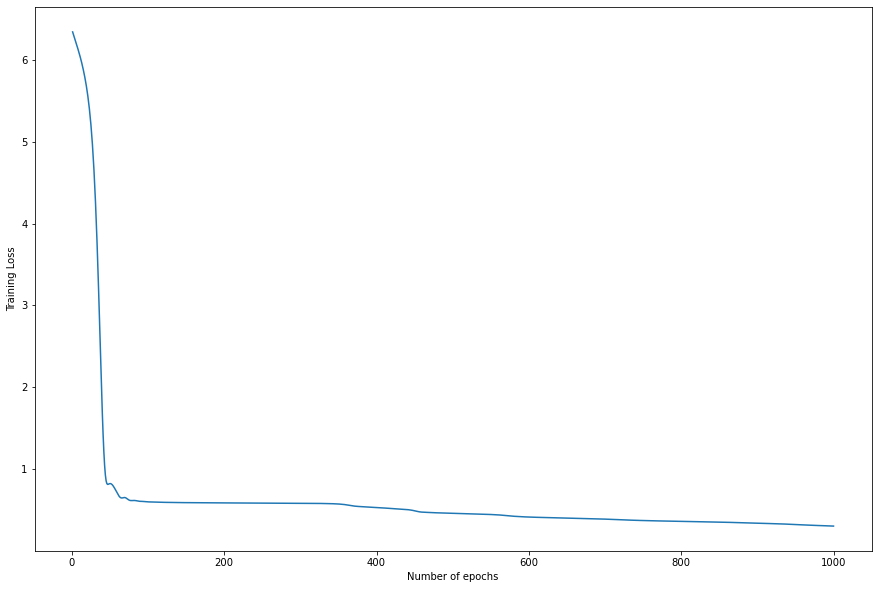

In [10]:
# Training loop starts
for epoch in range(num_epochs):
    
    # Generating output
    out = model(xt_tensor)
    hidden_feature = model.encoder(xt_tensor)
#         print('out', out.shape, out[0])
    query_hidden_feat = model.encoder(xq_learn_tensor)

    # Calculating loss
    if epoch == 0:
        print('out', out.shape, out) 
        print('xt_tensor', xt_tensor.shape, xt_tensor)
        print('hidden_feature', hidden_feature.shape, hidden_feature)
#         print('centroid_vectors', centroid_vectors.shape, centroid_vectors)
#         print('partition_id_list', partition_id_list.shape, partition_id_list)
        
    loss = loss_func(out, xt_tensor, xq_learn_tensor, hidden_feature, query_hidden_feat)

    # Updating weights according
    # to the calculated loss
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    clip_gradient = 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient) # clip gradieent
    optimizer.step()

    # Incrementing loss
    running_loss = loss.item()

    train_loss.append(running_loss)
    
#     out_val = model(x_val)
#     out_hidden = 
#     loss_val = loss_func(out_val, x_val)
#     validation_loss.append(loss_val)
    
    print("epoch:", epoch, "train loss:", running_loss)
#     print("epoch:", epoch, "train loss:", running_loss, "val loss: ", loss_val.item())

    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'in': xt_tensor, 'out': out}
    

# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
# plt.plot(range(1,num_epochs+1),validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

## K-means + Recall (on trained vec)

In [19]:
# Compute nearest neighbor
def scan_all(query_vec, vector_set):
    
    min_dist = 1e10
    min_dist_ID = None
    for vec_id, dataset_vec in enumerate(vector_set):
        dist = np.linalg.norm(query_vec - dataset_vec)
        if dist < min_dist:
            min_dist = dist
            min_dist_ID = vec_id
        elif dist == min_dist:
            print('tied distance, keep previous ID, skip current ID')
            
    return min_dist_ID

gt_xq_learn = [] 
for query in xq_learn:
    gt_xq_learn.append(scan_all(query, xt))
print(gt_xq_learn)

[7397]


In [12]:
from sklearn.cluster import KMeans

In [13]:
hidden_features_10K = model.encoder(torch.FloatTensor(xt)).detach().numpy()
print(hidden_features_10K.shape)
print(hidden_features_10K[0])

(10000, 32)
[-0.89485466  0.34480774  0.47402635 -0.06020072 -2.0539231   3.635032
 -0.62083983 -1.0993295   2.2461667  -3.6708348  -2.6218154  -0.898036
  2.2595727   1.3020664   0.54303455 -0.39367303  0.7861176  -2.4788344
 -0.96311283  2.5448287  -2.969053    1.7663007  -1.8186846  -1.5289774
 -1.1942096   1.2435136  -3.0043976   1.267514   -3.4240587  -1.1178623
  1.3548738  -1.2918974 ]


In [14]:
kmeans = KMeans(n_clusters=32)
kmeans.fit(hidden_features_10K)
partition_IDs = kmeans.predict(hidden_features_10K)
print(partition_IDs)
print(kmeans.cluster_centers_)

[ 3 25 25 ... 23 28  3]
[[-1.0519848   1.6776824  -0.6670559  ... -2.4929235   1.689954
  -0.56035924]
 [-1.0514224   0.47505525  1.6248525  ... -0.11530817 -0.01116067
  -2.0756214 ]
 [-1.1493677   1.8693256   0.4979278  ... -2.4362707   1.1461761
  -2.3129468 ]
 ...
 [-0.40516418  0.23725754  2.022428   ... -0.22720355 -0.0975706
  -2.1657333 ]
 [-0.57192934  0.08126658  1.8468227  ... -0.03009343 -0.1424846
  -2.093493  ]
 [-0.9624461   0.9851203   0.19244081 ... -1.1816211   1.0242264
  -0.6410636 ]]


In [15]:
# Create a mapping: partition ID -> {list of vector IDs}

num_partition = 32

partition_id_vec_id_list_100K = dict()
for i in range(num_partition):
    partition_id_vec_id_list_100K[i] = []


for i in range(num_vec_train):
    partition_ID = int(partition_IDs[i])
    partition_id_vec_id_list_100K[partition_ID].append(i)
    
for i in range(num_partition):
    print('items in partition ', i, len(partition_id_vec_id_list_100K[i]), 'average =', int(num_vec_train/num_partition))

items in partition  0 290 average = 312
items in partition  1 463 average = 312
items in partition  2 288 average = 312
items in partition  3 365 average = 312
items in partition  4 328 average = 312
items in partition  5 408 average = 312
items in partition  6 230 average = 312
items in partition  7 254 average = 312
items in partition  8 194 average = 312
items in partition  9 398 average = 312
items in partition  10 174 average = 312
items in partition  11 359 average = 312
items in partition  12 282 average = 312
items in partition  13 265 average = 312
items in partition  14 352 average = 312
items in partition  15 172 average = 312
items in partition  16 406 average = 312
items in partition  17 197 average = 312
items in partition  18 182 average = 312
items in partition  19 177 average = 312
items in partition  20 282 average = 312
items in partition  21 330 average = 312
items in partition  22 343 average = 312
items in partition  23 354 average = 312
items in partition  24 359

In [16]:
import heapq

def scan_partition(query_vec, partition_id_list, vector_set):
    """
    query_vec = (128, )
    partition_id_list = (N_num_vec, )
    vector_set = 1M dataset (1M, 128)
    """
    min_dist = 1e10
    min_dist_ID = None
    for vec_id in partition_id_list:
        dataset_vec = vector_set[vec_id]
        dist = np.linalg.norm(query_vec - dataset_vec)
        if dist <= min_dist:
            min_dist = dist
            min_dist_ID = vec_id
            
    return min_dist_ID

In [17]:
nearest_neighbors = []

N = num_query_learn
print('N=', N)
#### Wenqi: here had a bug: previously xb, now xq
query_hidden_feature = model.encoder(torch.FloatTensor(xq)).detach().numpy()
print(query_hidden_feature.shape)
query_partition = kmeans.predict(query_hidden_feature)

for i in range(N):
    partition_id = int(query_partition[i])
    nearest_neighbor_ID = scan_partition(xq[i], partition_id_vec_id_list_100K[partition_id], xb)
    nearest_neighbors.append(nearest_neighbor_ID)
    print(i, nearest_neighbor_ID)

N= 1
(10000, 32)
0 7408


In [18]:
correct_count = 0
for i in range(N):
    if nearest_neighbors[i] == gt_xq_learn[i]:
        correct_count += 1
        
print(correct_count, 'recall@1 = ', correct_count / N)

0 recall@1 =  0.0


## K-means + Recall (on 1M vec)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
hidden_features_10K = model.encoder(torch.FloatTensor(xt)).detach().numpy()
print(hidden_features_10K.shape)
print(hidden_features_10K[0])

In [ ]:
kmeans = KMeans(n_clusters=32)
kmeans.fit(hidden_features_10K)
y_kmeans = kmeans.predict(hidden_features_10K)
print(y_kmeans)

In [ ]:
hidden_feature_1M = model.encoder(torch.FloatTensor(xb)).detach().numpy()

partition_IDs = kmeans.predict(hidden_feature_1M)
print(partition_IDs)
print(partition_IDs.shape)

In [ ]:
# Create a mapping: partition ID -> {list of vector IDs}

num_partition = 32

partition_id_vec_id_list_1M = dict()
for i in range(num_partition):
    partition_id_vec_id_list_1M[i] = []


for i in range(int(1e6)):
    partition_ID = int(partition_IDs[i])
    partition_id_vec_id_list_1M[partition_ID].append(i)
    
for i in range(num_partition):
    print('items in partition ', i, len(partition_id_vec_id_list_1M[i]), 'average =', int(1e6/num_partition))


In [ ]:
import heapq

def scan_partition(query_vec, partition_id_list, vector_set):
    """
    query_vec = (128, )
    partition_id_list = (N_num_vec, )
    vector_set = 1M dataset (1M, 128)
    """
    min_dist = 1e10
    min_dist_ID = None
    for vec_id in partition_id_list:
        dataset_vec = vector_set[vec_id]
        dist = np.linalg.norm(query_vec - dataset_vec)
        if dist <= min_dist:
            min_dist = dist
            min_dist_ID = vec_id
            
    return min_dist_ID

In [ ]:
nearest_neighbors = []

N = num_query_learn
print('N=', N)
#### Wenqi: here had a bug: previously xb, now xq
query_hidden_feature = model.encoder(torch.FloatTensor(xq)).detach().numpy()
print(query_hidden_feature.shape)
query_partition = kmeans.predict(query_hidden_feature)

for i in range(N):
    partition_id = int(query_partition[i])
    nearest_neighbor_ID = scan_partition(xq[i], partition_id_vec_id_list_1M[partition_id], xb)
    nearest_neighbors.append(nearest_neighbor_ID)
    print(i, nearest_neighbor_ID)

In [ ]:
# Recall (first 10 query vec to overfit; 1000 iteration)

In [ ]:
correct_count = 0
for i in range(N):
    if nearest_neighbors[i] == gt[i][0]:
        correct_count += 1
        
print(correct_count, 'recall@1 = ', correct_count / N)